In [1]:
### IMPORTS ###
folder0 = '/home/yuriko/UCM_projects/Floquet_ttp/ZenodoRepo/'

import sys
sys.path.append(folder0)

from Func_Floquet_classes import *
from matplotlib import cm
from IPython.display import Math
from sympy.interactive import printing

## Personalized plots
from matplotlib.lines import Line2D
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{bm,amsmath,amsfonts,amssymb,bbold}"
from Func_general import *
plotParams('paper')
%matplotlib inline

## Units conversion
import scipy.constants as sconst

In [12]:
import scipy 
scipy.__version__

'1.11.1'

In [2]:
###############################
### Bi2Se3 Hamiltonian:

def calcBi2Se3(paramsBi2Se3):
    pZ = SimpleNamespace(**paramsBi2Se3)
    v0eff = pZ.v0 * pZ.a1
    C0eff, C2eff, R1eff = (pZ.C0 + pZ.a3 * pZ.M0), (pZ.C2 + pZ.a3 * pZ.M2), (0.5 * pZ.R1 * pZ.a1)
    C0eff = 0  # we are setting onsite constant term to 0
    pB = dict(**paramsBi2Se3, C0eff=C0eff, C2eff=C2eff, R1eff=R1eff, v0eff=v0eff)
    return pB

paramsBi2Se3 = calcBi2Se3({'C0': -0.0083, 'C2': 30.4, 'M0': -0.28, 'M2': 44.5, 'v0': 3.33,
                           'R1': 50.6, 'a1': 0.99, 'a3': -0.15})  # in units of eV and Angstrom

omega_eV = 0.160 #eV
paramsPulse = dict(adim=1 / omega_eV,  polar='linearx', theta=0)
pB = SimpleNamespace(**paramsBi2Se3, **paramsPulse)

hbar_eVs = sconst.physical_constants['reduced Planck constant in eV s'][0]
t_THZ = omega_eV/(2*np.pi*hbar_eVs)*1e-12


# Bi_2Se_3 model
## Static Floquet picture

In [6]:
ham_symbols = sp.symbols("W C_0 C_2 v_0 R_1", real=True)
ham_dict = {str(b): b for b in ham_symbols}
locals().update( ham_dict)

hBi2Se3 = Hamiltonian(
    h0_k = W * (C_0 * s0 + C_2 * (k_x ** 2 + k_y ** 2) * s0
                     + v_0 * (k_y * sx - k_x * sy) 
                        + R_1 * ((k_x+1j*k_y) ** 3 + (k_x-1j*k_y) ** 3) * sz),
    Axt=A_x * sp.sin(2 * sp.pi / T_p * t_sp),
    Ayt=A_y * sp.sin(2 * sp.pi / T_p * t_sp + sp.pi / 2),  
    ham_symbols=ham_symbols)

In [5]:
## Define the Floquet-Fourier Hamiltonian, we let some variables to be modified later

par_var = {'k_x': None, 'k_y': None, 'A_x': None, 'A_y': None}
par_fix = {'C_0' : pB.C0eff, 'C_2': pB.C2eff, 'v_0': pB.v0eff, 'R_1': pB.R1eff,'W': 1/0.160}

hBi2Se3FF = Hamiltonian_FloquetFourier(hBi2Se3,par_var, par_fix =  par_fix,  N = 40)

## Check the Fourier elements calculated by the SymPy integrals
Math('$Q_0 = {}, Q_1 = {},  Q_2 = {}$'.format(
    printing.default_latex(hBi2Se3.fourier_elements(0)), 
    printing.default_latex(hBi2Se3.fourier_elements(1)), 
    printing.default_latex(hBi2Se3.fourier_elements(2))))


<IPython.core.display.Math object>

0.0485333818667152
0.0970667637334304
0.1941335274668608


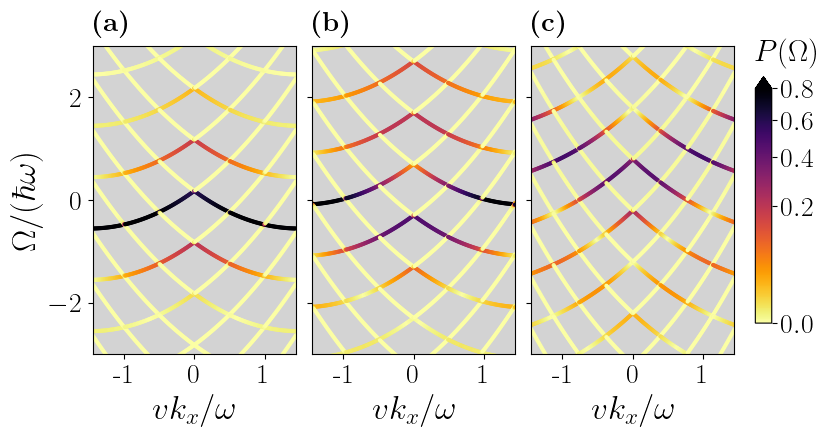

In [6]:
## Figure 8:

momentax = np.linspace(-0.07, 0.07, 201) 
Alist = 1/(pB.v0eff*par_fix['W'])*np.array([1, 2, 4])

fig, axs = plt.subplots(1, 3, figsize=(3 * 3, 4), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.08)

for ax, Aval, cbar in zip(axs, Alist, [False, False, True]):
    par = {'k_y': 0., 'A_x': Aval, 'A_y': 0.}
    obs = ObservablesFF(hBi2Se3FF, 'k_x', momentax, params = par)
    out = obs.photoelAmpPlot(ax = ax, Nmax=20, cbar=cbar, fig = fig, axs = axs, vmax = 0.8)
    if Aval > Alist[0]:
        ax.set(ylabel = None)
axs[0].set(ylabel = r'$\Omega/(\hbar \omega)$', ylim = (-3,3), xlim = (-0.07, 0.07))
k0 = 1/(pB.v0eff*par_fix['W'])
[ax.set(xticks = [-k0, 0, k0], xticklabels = [-1,0,1])]
out[1].ax.set_title(r'', fontsize=18, y=1.2, pad=-14)
out[1].ax.set_title(r'$P(\Omega)$', fontsize=22, y=1.2, pad=-14, loc = 'left')
createletters(axs, coord = [0, 1.05])

fig.savefig(folder0+'/FigsPaper/DOS_BSLin.pdf', bbox_inches='tight')

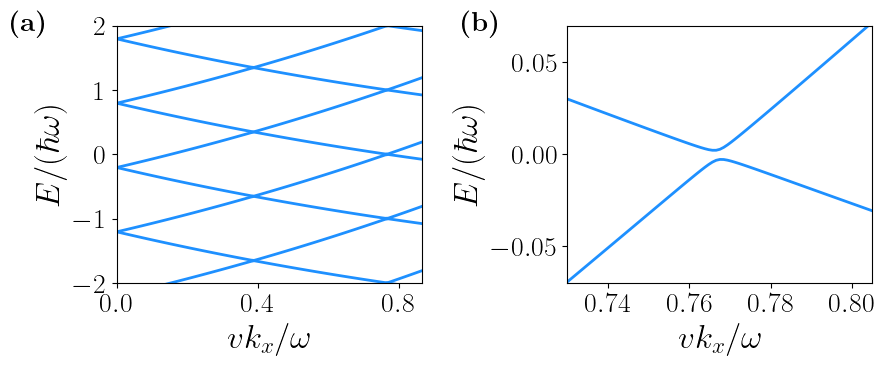

In [7]:
## Figure 7 

A0 = 1/(pB.v0eff*par_fix['W'])
momentax = np.linspace(0, 0.042, 101) 

par = {'k_y': 0., 'A_x': A0*4, 'A_y': 0.}
obs = ObservablesFF(hBi2Se3FF, 'k_x', momentax, params = par)
ens = obs.ens
fig, axs = plt.subplots(1,2, figsize=(3 * 3, 4))

k0 = 1/(pB.v0eff*par_fix['W'])
kprop = pB.v0eff*par_fix['W']
[ax.set(xticks = [-k0, 0, k0], xticklabels = [-1,0,1])]

axs[0].plot(momentax*kprop, ens, c='dodgerblue', lw = 2)
axs[0].set(ylim = (-2,2), xlim = (0,0.042*kprop), xticks = np.arange(0,0.82, 0.4))

# momentax2 = np.linspace(0.0175, 0.019, 101)
momentax2 = np.linspace(0.035, 0.0395, 101)
obs2 = ObservablesFF(hBi2Se3FF, 'k_x', momentax2, params = par)
ens2 = obs2.ens
axs[1].plot(momentax2*kprop, ens2, c='dodgerblue', lw = 2)
axs[1].set(ylim = (-0.07, 0.07), xlim = (0.73, 0.805), xticks = (0.74, 0.76, 0.78, 0.8))
    # ylim=(0.49,0.54), xlim = (0.0175, 0.019)) #, xticks = (0.0240, 0.0245))

for ax in axs:
    ax.set_xlabel(r'$v k_x/\omega$')
    ax.set_ylabel(r'$E/(\hbar \omega)$')
plt.tight_layout()
createletters(axs, coord=[-0.35, 0.98])
fig.savefig(folder0+'/FigsPaper/Bi2Se3_gap.pdf', bbox_inches='tight')


## Floquet t-t' formalism

In [8]:
## Define the Floquet t-t' Hamiltonian

par_fix = {'C_0' : pB.C0eff, 'C_2': pB.C2eff, 'v_0': pB.v0eff, 'R_1': pB.R1eff,'W': 1/0.160, 'T_p' : 1.}
params_env = {'mu_sp' : 3., 'tau_sp' : 2. , 'A_x': 0.15, 'A_y':0, 'A_z': 0}
params_ham = {'k_x' : 0.1, 'k_y' : 0.0}

ham_symbols = sp.symbols("W C_0 C_2 v_0 R_1 mu_sp tau_sp", real=True)
ham_dict = {str(b): b for b in ham_symbols}
locals().update( ham_dict)

hBi2Se3_pulse = Hamiltonian_ttp(
    h0_k = W * (C_0 * s0 + C_2 * (k_x ** 2 + k_y ** 2) * s0
                     + v_0 * (k_y * sx - k_x * sy) + R_1 * ((k_x+1j*k_y) ** 3 + (k_x-1j*k_y) ** 3) * sz),
    par_var_ham = params_ham,
    par_fix = par_fix,
    Vxt= sp.sin(2 * sp.pi / T_p * t_sp),
    Vyt= sp.sin(2 * sp.pi / T_p * t_sp + sp.pi / 2), 
    Axenv = A_x * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2),
    Ayenv = A_y * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2) , 
    ham_symbols=ham_symbols,
    N = 50) #Importat: add N large!

## Quantities for adim 
A0 = 1./(pB.v0eff*par_fix['W'])
kprop = pB.v0eff*par_fix['W']

State at t = 0.00 energy = -0.1912, wf (spinor): [-0.707+0.j     0.   -0.708j]


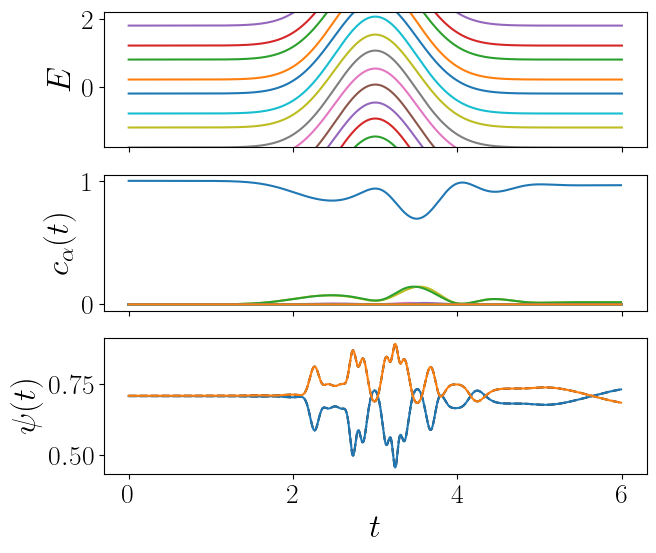

State at t = 0.00 energy = -0.5872, wf (spinor): [-0.698+0.j     0.   -0.716j]


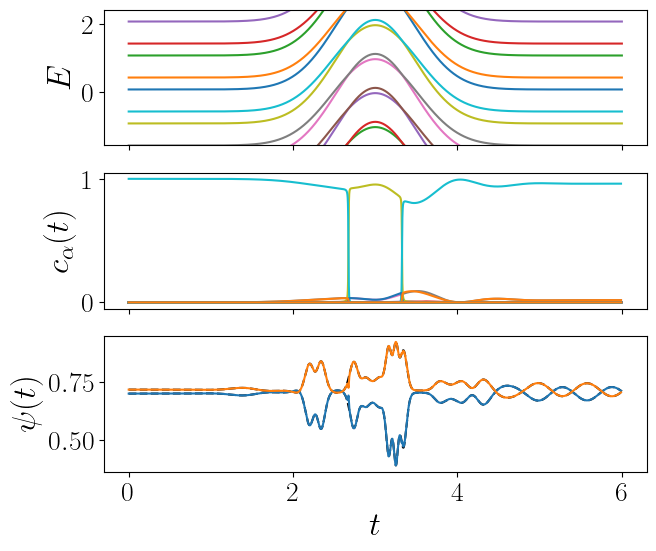

In [5]:
## Data Figure 9 ###

psi0band, T = 0, 1.
ts_fig9 = np.linspace(0, 6 * T, 8000) + 1e-6
ks = [0.01, 0.04]

calc = True

if calc:
    solverL1 = []
    data  = []
    for ki in ks:
        params_env = {'mu_sp' : 3., 'tau_sp' : 1. , 'A_x': A0*4, 'A_y':0, 'A_z': 0}
        params_ham = {'k_x' : ki, 'k_y' : 0.0,}
        params_full = {**params_ham}
        solver_ki = IFS_solver(hBi2Se3_pulse, ts_fig9, params_env, params_full, Nmax = 15)
        params_env = {'mu_sp' : 3., 'tau_sp' : 1. , 'A_x': A0*4, 'A_y':0, 'A_z': 0}
        params_ham = {'k_x' : ki, 'k_y' : 0.0,}
        UsC= hBi2Se3_pulse.time_evolutionU(dict(**params_env, **params_ham, **par_fix), ts_fig9, steps = True)
        ct, psitsol = solver_ki.c_t(psi0band=psi0band, tend=5.99, psi_t=True)
        ts_ct = ts_fig9[:len(ct)]
        
        fig, axs = plt.subplots(3,1,figsize = (7, 6), sharex = True)
        axs[0].plot(ts_fig9, solver_ki.eL)
        mide = solver_ki.eL[0][len(solver_ki.eL[0])//2]
        axs[0].set(ylabel = r'$E$', xlabel = '', ylim = (mide-2, mide+2))
        axs[1].plot(ts_ct, np.abs(ct)**2)
        axs[1].set(ylabel = r'$|c_\alpha(t)|^2$', xlabel = '')
        axs[2].plot(ts_fig9, np.abs(UsC@psitsol[0]), ls = '--', c= 'k')
        axs[2].plot(ts_ct, np.abs(psitsol))
        axs[2].set(ylabel = r'$\psi(t)$', xlabel = '$t$')
        plt.show()
        data.append({'tagvec':solver_ki.tag_fqlevels(), 'indexCbase' : solver_ki.indexCbase, 'eL':solver_ki.eL, 
                     'ct':ct, 'psit':psitsol, 'psiTDSE': UsC@psitsol[0], 'ts' : ts_fig9, 
                     'ts_ct': ts_ct, **params_env, **params_ham})
    np.save(folder0+'FigsPaper/fig_Bi2Se3Lin_calphaData', data)
else:
    data = np.load(folder0+'FigsPaper/fig_Bi2Se3Lin_calphaData.npy', allow_pickle=True)

[0.20604375 0.824175  ]


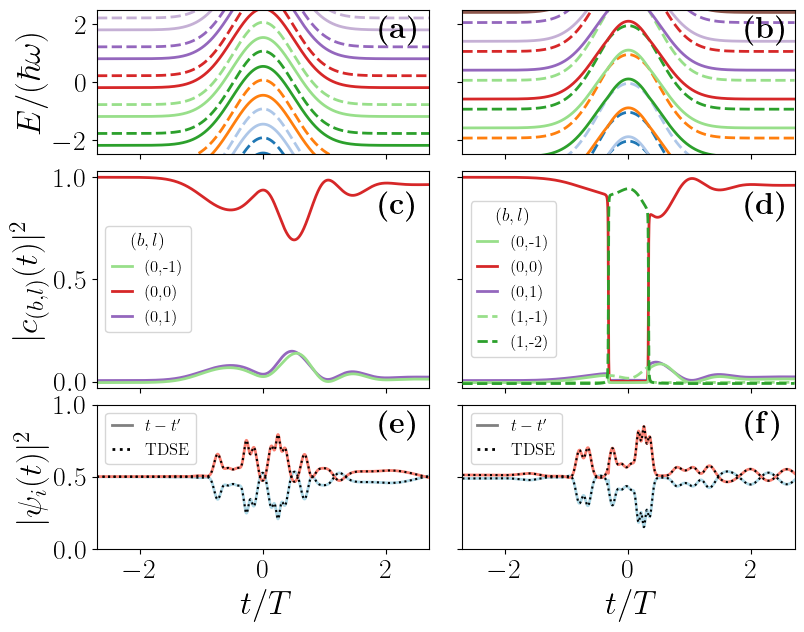

In [6]:
## Figure 9 ###

fig, axsall = plt.subplots(3,2,figsize = (9, 7), sharex = True, sharey = 'row', height_ratios=[2, 3, 2])
plt.subplots_adjust(hspace=0.1, wspace = 0.1)

Nplot = 4
cmap = cm.tab20
norm = mpl.colors.Normalize(vmin = -5, vmax = 10)

lines = [Line2D([0], [0], color='k', linewidth=2, linestyle=ls)  for ls in ['-', '--']]
lab_lines = ['$b = 0$', '$b = 1$']

linespsit = [Line2D([0], [0], color=c, linewidth=2, linestyle=ls)  for c, ls in zip(['grey', 'k'], ['-', ':'])]
lab_linespsit = ['$t-t^\prime$', 'TDSE'] 

for axs, datai in zip(axsall.T, data):
    for cti, i  in enumerate(datai['indexCbase']) :
        l, m = datai['tagvec'][i] 
        ls = '-' if l == 0 else '--'
        label = '({},{})'.format(int(l),int(m)) if (np.max(abs(datai['ct'][:,cti]))>0.1) else None
        if np.max(datai['ct'][:,cti]**2)> 0.05: ##Plot only the c_alpha which are c^2 > 0.05
            axs[1].plot(datai['ts_ct']-3, (np.abs(datai['ct'][:, cti]) ** 2)+0.005*m, lw=2, c=cmap(norm(m)), 
                        zorder = -(m)+l, ls = ls, label = label) # We are adding a small offset to distinguish the curves that otherwise overlap
        axs[0].plot(datai['ts']-3, datai['eL'][:, i], lw = 2, c=cmap(norm(m)), ls = ls, label = label)
            
    axs[2].plot(datai['ts_ct']-3, np.abs(datai['psit'][:,0])**2, c = 'lightblue', lw = 2)
    axs[2].plot(datai['ts_ct']-3, np.abs(datai['psit'][:,1])**2, c = 'salmon', lw = 2)
    axs[2].plot(datai['ts']-3, np.abs(datai['psiTDSE'])**2, ls = ':', c= 'k')
    axs[2].legend(linespsit, lab_linespsit, handlelength = 1.2, fontsize = 12, loc = 'upper left')
    
    handles, labels = axs[1].get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    lg_col = axs[1].legend(handles, labels, fontsize = 12, handlelength = 1.2, ncols = 1, loc='center left', title=r"$(b,l)$",)
    lg_col.get_title().set_fontsize('13')
    
axsall[2,0].set(ylabel = r'$|\psi_i(t)|^2$', xlabel = '$t$', ylim = (0,1))
axsall[0,0].set(ylabel = r'$E/(\hbar \omega)$', xlabel = '', ylim = (-2.5, 2.5), yticks = [-2, 0, 2])
axsall[1,0].set(ylabel = r'$|c_{(b,l)}(t)|^2$', xlabel = '', ylim = (-0.03, 1.03))
[ax.set(xlabel = r'$t/T$', xlim = (-2.7,2.7)) for ax in axsall[-1]]
createletters(axsall.ravel(), coord=[0.85, 0.8], SMALL_SIZE=22)
fig.savefig(folder0+'/FigsPaper/fig_Bi2Se3Lin_calpha.pdf', bbox_inches='tight', transparent = True)

print(kprop*np.array(ks))

## Dirac model with only Quadratic terms or only Trigonal warping

In [8]:
## Parameter sets for the different contributions in the Bi2Se3 Hamiltonian: 

par_fixBi2Se3 = {'C_0' : pB.C0eff, 'C_2': pB.C2eff, 'v_0': pB.v0eff, 'R_1': pB.R1eff,'W': 1/0.160, 'T_p':1.}
par_fixQuad = {'C_0' : pB.C0eff, 'C_2': pB.C2eff, 'v_0': pB.v0eff, 'R_1': 0,'W': 1/0.160, 'T_p':1.}
par_fixTrigw = {'C_0' : 0., 'C_2': 0., 'v_0': pB.v0eff, 'R_1': pB.R1eff,'W': 1/0.160, 'T_p':1.}
par_fixLin = {'C_0' : 0., 'C_2': 0., 'v_0': pB.v0eff, 'R_1': 0,'W': 1/0.160, 'T_p':1.}

par_var = {'k_x': None, 'k_y': None, 'A_x': None, 'A_y': None}

## List of models: Quad for the Dirac with quadratic onsite and Triw for the Dirac with trigonal warping
par_fixL = [par_fixQuad, par_fixTrigw]
hModL = [Hamiltonian_ttp(
    h0_k = W * (C_0 * s0 + C_2 * (k_x ** 2 + k_y ** 2) * s0
                + v_0 * (k_y * sx - k_x * sy) + R_1 * ((k_x+1j*k_y) ** 3 + (k_x-1j*k_y) ** 3) * sz),
    par_var_ham = params_ham, par_fix = par_fix,
    Vxt= sp.sin(2 * sp.pi / T_p * t_sp), Axenv = A_x * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2),
    ham_symbols=ham_symbols, N = 50) 
         for par_fix in par_fixL]

State at t = 0.00 energy = -0.5869, wf (spinor): [-0.707+0.j     0.   -0.707j]


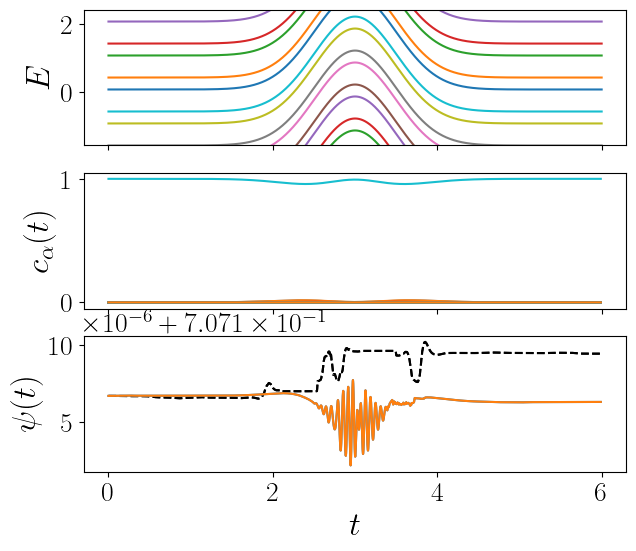

State at t = 0.00 energy = -0.8244, wf (spinor): [-0.698+0.j     0.   -0.716j]


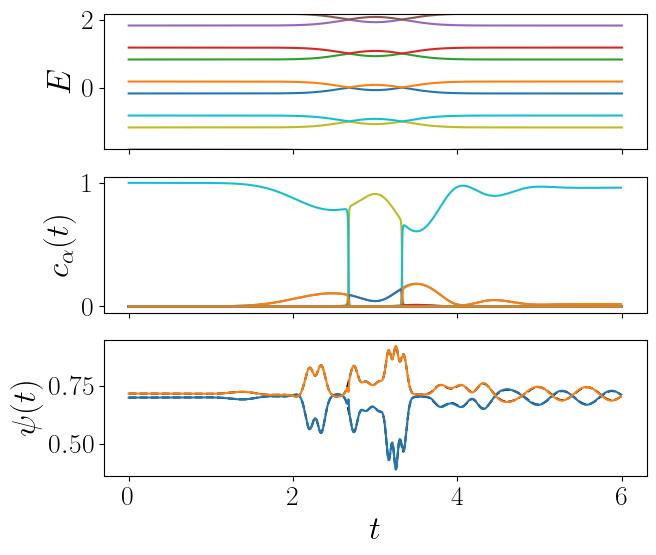

In [10]:
## Data Figure 10

psi0band, T = 0, 1. 
ts_fig10 = np.linspace(0, 6 * T, 8000) + 1e-5
calc = True

if calc:
    data  = []
    for ham, par_fix, name in zip(hModL, par_fixL, ['Quad', 'Trigw']):
        params_env = {'mu_sp' : 3., 'tau_sp' : 1 , 'A_x': A0*4, 'A_y':0, 'A_z': 0}
        params_ham = {'k_x' : 0.04, 'k_y' : 0.0,}
        params_full = {**params_ham}
        solver_ifs = IFS_solver(ham, ts_fig10, params_env, params_full, Nmax = 15)
    
        UsC= ham.time_evolutionU(dict(**params_env, **params_ham, **par_fix), ts_fig10, steps = True)
        ct, psitsol = solver_ifs.c_t(psi0band=psi0band, tend=5.99, psi_t=True)
        ts_ct = ts_fig10[:len(ct)]
        
        fig, axs = plt.subplots(3,1,figsize = (7, 6), sharex = True)
        axs[0].plot(ts_fig10, solver_ifs.eL)
        mide = solver_ifs.eL[0][len(solver_ifs.eL[0])//2]
        axs[0].set(ylabel = r'$E$', xlabel = '', ylim = (mide-2, mide+2))
        axs[1].plot(ts_ct, np.abs(ct)**2)
        # axs[1].plot(ts1, Alist[:,0], c = 'k')
        axs[1].set(ylabel = r'$c_\alpha(t)$', xlabel = '')
        axs[2].plot(ts_fig10, np.abs(UsC@psitsol[0]), ls = '--', c= 'k')
        axs[2].plot(ts_ct, np.abs(psitsol))
        axs[2].set(ylabel = r'$\psi(t)$', xlabel = '$t$')
        plt.show()
        data.append({'tagvec':solver_ifs.tag_fqlevels(),
                       'indexCbase' : solver_ifs.indexCbase,
                       'eL':solver_ifs.eL, 'ct':ct, 'psit':psitsol,
                     'psiTDSE': UsC@psitsol[0], 'ts' : ts_fig10, 'ts_ct': ts_ct, **params_env, **params_ham})
    np.save(folder0+'/FigsPaper/fig_Bi2Se3Lin_CompModels', data)
else:
    data = np.load(folder0+'/FigsPaper/fig_Bi2Se3Lin_CompModels.npy', allow_pickle=True)
    ts_fig10 = data[0]['ts']

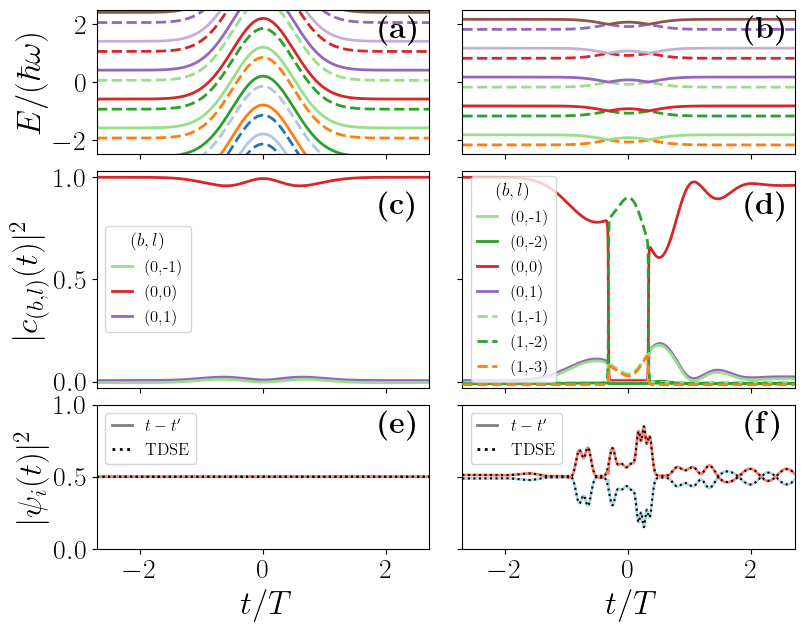

In [11]:
### Figure 10: ###

fig, axsall = plt.subplots(3,2,figsize = (9, 7), sharex = True, sharey = 'row', height_ratios=[2, 3, 2])
plt.subplots_adjust(hspace=0.1, wspace = 0.1)

Nplot = 4
cmap = cm.tab20
norm = mpl.colors.Normalize(vmin = -5, vmax = 10)

lines = [Line2D([0], [0], color='k', linewidth=2, linestyle=ls)  for ls in ['-', '--']]
lab_lines = ['$b = 0$', '$b = 1$']

linespsit = [Line2D([0], [0], color=c, linewidth=2, linestyle=ls)  for c, ls in zip(['grey', 'k'], ['-', ':'])]
lab_linespsit = ['$t-t^\prime$', 'TDSE']

for axs, datai in zip(axsall.T, data):
    for cti, i  in enumerate(datai['indexCbase']) :
        l, m = np.nan_to_num(datai['tagvec'][i]) 
        ls = '-' if l == 0 else '--'
        label = '({},{})'.format(int(l),int(m)) 
        if np.max(datai['ct'][:,cti]**2)> 0.007:    
            axs[1].plot(datai['ts_ct']-3, (np.abs(datai['ct'][:, cti]) ** 2)+0.005*m, lw=2, c=cmap(norm(m)), 
                        zorder = -(m)+l, ls = ls, label = label)
        axs[0].plot(datai['ts']-3, datai['eL'][:, i], lw = 2, c=cmap(norm(m)), ls = ls, label = label)
    
    axs[2].plot(datai['ts_ct']-3, np.abs(datai['psit'][:,0])**2, c = 'lightblue', lw = 2)
    axs[2].plot(datai['ts_ct']-3, np.abs(datai['psit'][:,1])**2, c = 'salmon', lw = 2)
    axs[2].plot(datai['ts']-3, np.abs(datai['psiTDSE'])**2, ls = ':', c= 'k')
    axs[2].legend(linespsit, lab_linespsit, handlelength = 1.2, fontsize = 12, loc = 'upper left')
    
    handles, labels = axs[1].get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    lg_col = axs[1].legend(handles, labels, fontsize = 12, handlelength = 1.2, ncols = 1, loc='center left', title=r"$(b,l)$",)
    lg_col.get_title().set_fontsize('13')
    
axsall[2,0].set(ylabel = r'$|\psi_i(t)|^2$', xlabel = '$t$', ylim = (0,1))
axsall[0,0].set(ylabel = r'$E/(\hbar \omega)$', xlabel = '', ylim = (-2.5, 2.5), yticks = [-2, 0, 2])
axsall[1,0].set(ylabel = r'$|c_{(b,l)}(t)|^2$', xlabel = '', ylim = (-0.03, 1.03))
[ax.set(xlabel = r'$t/T$', xlim = (-2.7,2.7)) for ax in axsall[-1]]
createletters(axsall.ravel(), coord=[0.85, 0.8], SMALL_SIZE=22)
fig.savefig(folder0+'/FigsPaper/fig_Bi2Se3Lin_CompModels.pdf', bbox_inches='tight', transparent = True)

In [9]:
## t-t' Hamiltonian for the loop calculation in Fig 11

par_fix = {'C_0' : pB.C0eff, 'C_2': pB.C2eff, 'v_0': pB.v0eff, 'R_1': pB.R1eff,'W': 1/0.160, 'T_p' : 1.}

params_env = {'mu_sp': 3.5, 'tau_sp': 1.5, 'A_x': A0*4., 'A_y': 0.0, 'A_z': 0}
params_ham = {'k_x' :None, 'k_y' : None,}



hBi2Se3_pulse = Hamiltonian_ttp(
    h0_k = W * (C_0 * s0 + C_2 * (k_x ** 2 + k_y ** 2) * s0
                     + v_0 * (k_y * sx - k_x * sy) + R_1 * ((k_x+1j*k_y) ** 3 + (k_x-1j*k_y) ** 3) * sz),
    par_var_ham = params_ham, par_fix = par_fix,
    Vxt= sp.sin(2 * sp.pi / T_p * t_sp),
    Axenv = A_x * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2),
    ham_symbols=ham_symbols, N = 40) ## We reduce the number of Fourier replicas to speed up a bit the loop



In [13]:
# Data Figure 11 and extra pannels 

calc = False

ts = np.linspace(1e-4, 7.1, 8000)
ks = np.arange(-0.07, 0.07, 0.0025) + 0.0001 ## offset to avoid the numerical degenerancy at the Dirac point

Ax = 4.*A0 
psi0band = 0


if calc: 
    for kx in ks:
        params_env = {'mu_sp': 3.5, 'tau_sp': 1.5, 'A_x': Ax, 'A_y': 0., 'A_z': 0.}
        params_ham = {'k_x': kx, 'k_y': 0.0, } 
        solver_ifs = IFS_solver(hBi2Se3_pulse, ts, params_env, params_ham, Nmax=12)
        ct, psitsol = solver_ifs.c_t(psi0band=psi0band, tend=7., psi_t=True)
        UsC= hBi2Se3_pulse.time_evolutionU(dict(**params_env, **params_ham, **par_fix), ts, steps = True)
        
        np.savez(folder0 + 'FigsPaper/Data_ifs/Ct_Ax{:.2f}_Ay{}_kx{:.4f}_ky{}.npz'.format(
            params_env['A_x'], params_env['A_y'], kx, params_ham['k_y'], ),
             ts=ts, ct=ct, e0=nla.eigvalsh(solver_ifs.ham0),
             UsC=UsC, psitsol=psitsol, eL=solver_ifs.eL, tagvec=solver_ifs.tag_fqlevels(),
             indexCbase = solver_ifs.indexCbase)
else:
    
    def import_data(kx):    
        return np.load(folder0+'FigsPaper/Data_ifs/Ct_Ax{:.2f}_Ay{}_kx{:.4f}_ky{}.npz'.format(
            params_env['A_x'], params_env['A_y'], kx, params_ham['k_y'], ))
    data= []
    for kx in ks:
        datai= import_data(kx)
        params_ham = {'k_x': kx, 'k_y': 0.0, }
        data.append({'tagvec':datai['tagvec'], 'indexCbase' : datai['indexCbase'],
                     'eL': datai['eL'], 'ct':datai['ct'], 'psit': datai['psitsol']})
    ts = datai['ts']


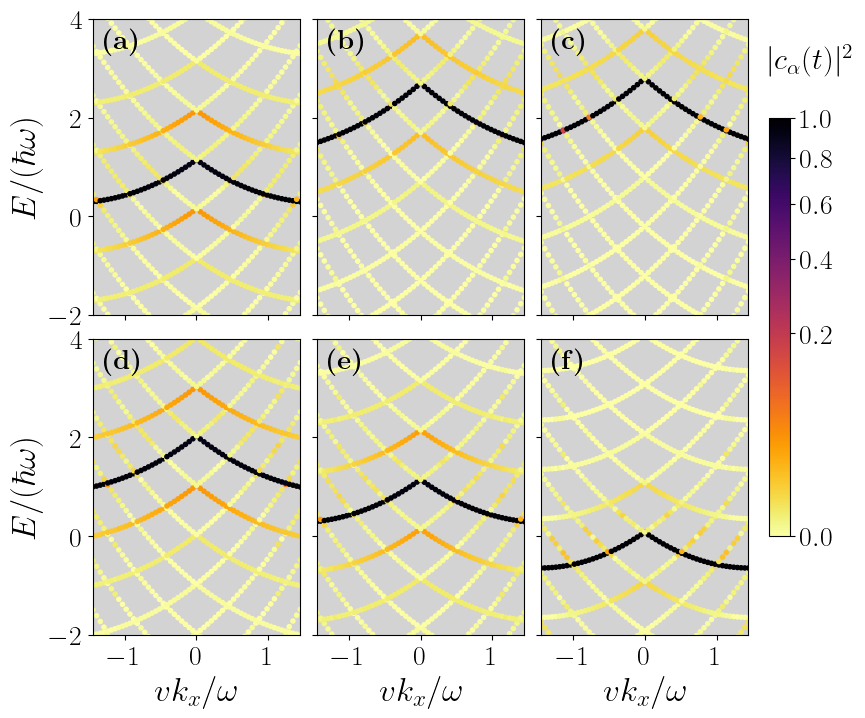

In [17]:
## Figure 11 extra pannels

fig, axs = plt.subplots(2, 3, figsize=(3 * 3, 8), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.08, hspace=0.08)

t_sel = np.array([-1, -0.2, 0, 0.6, 1., 2.])+3.5
inds_t = [np.argmin(np.abs(ts-ti)) for ti in t_sel]

cmap = mpl.colormaps['inferno_r']
norm = mpl.colors.PowerNorm(vmin=0, vmax=1, gamma=0.45)

for ti, ax in zip(inds_t, axs.ravel()):
    eL = np.array([datai['eL'][ti] for datai in data])
    ct_k = np.array([datai['ct'] for datai in data])
    indexCbase_k = np.array([datai['indexCbase'] for datai in data])
    col_k = np.abs(ct_k[:,ti]) ** 2
    ensL = np.array([eL[ki, indexCbase_k[ki]] for ki in range(len(ks))])
    for nband in range(len(indexCbase_k[0])):
        z1 = ax.scatter(ks*kprop, ensL[:,nband], c=col_k[:,nband], s=9, cmap=cmap, norm=norm, zorder = nband-50)
    ax.set(facecolor='lightgrey')
[ax.set(ylabel=r'$E/(\hbar \omega)$', ylim=(-2, 4), xlim=(-0.07*kprop, 0.07*kprop)) for ax in axs[:,0]]
[ax.set(xlabel=(r'$vk_x/\omega$')) for ax in axs[1]]
cbar_ax = fig.colorbar(cm.ScalarMappable(cmap=cmap,  norm = norm), 
                       ax=axs, pad=0.03, shrink=0.95, aspect=20, fraction=0.03,)
cbar_ax.ax.set_title(r'$|c_\alpha(t)|^2$', fontsize=22, y=1.15, pad=-10, loc='left')
createletters(axs.ravel(), coord=[0.05, 0.9])

fig.savefig(folder0+'/FigsPaper/Spectrum_Bi2Se3_cs_6panels.pdf', bbox_inches='tight')

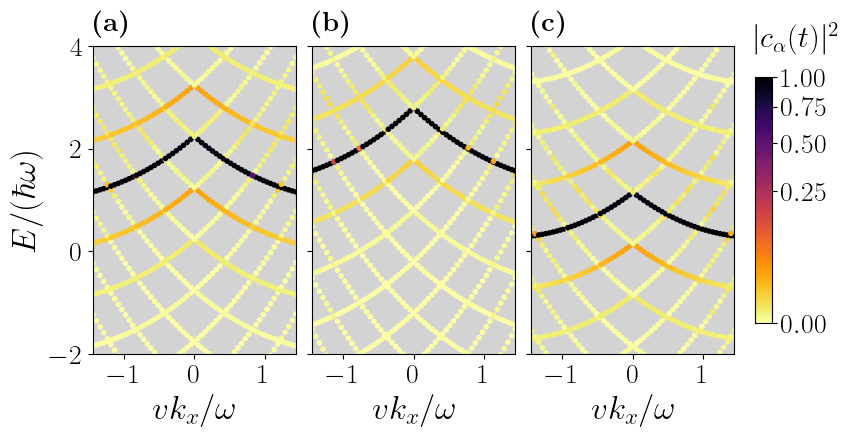

In [16]:
## Figure 11 

fig, axs = plt.subplots(1, 3, figsize=(3 * 3, 4), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.08)

t_sel = np.array([-0.5, 0, 1.]) + 3.5
inds_t = [np.argmin(np.abs(ts - ti)) for ti in t_sel]

cmap = mpl.colormaps['inferno_r']
norm = mpl.colors.PowerNorm(vmin=0, vmax=1, gamma=0.45)

for ti, ax in zip(inds_t, axs.ravel()):
    eL = np.array([datai['eL'][ti] for datai in data])
    ct_k = np.array([datai['ct'] for datai in data])
    indexCbase_k = np.array([datai['indexCbase'] for datai in data])
    col_k = np.abs(ct_k[:,ti]) ** 2
    ensL = np.array([eL[ki, indexCbase_k[ki]] for ki in range(len(ks))])
    for nband in range(len(indexCbase_k[0])):
        z1 = ax.scatter(ks*kprop, ensL[:,nband], c=col_k[:,nband], s=9, cmap=cmap, norm=norm) 
    ax.set(facecolor='lightgrey', xlabel=(r'$vk_x/\omega$'), xticks = (-1, 0, 1))
axs[0].set(ylabel=r'$E/(\hbar \omega)$', ylim=(-2, 4), xlim=(-0.07*kprop, 0.07*kprop))
cbar_ax = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),
                       ax=axs, pad=0.03, shrink=0.8, aspect=15, fraction=0.05,)
cbar_ax.ax.set_title(r'$|c_\alpha(t)|^2$', fontsize=22, y=1.2, pad=-14, loc='left')
createletters(axs.ravel(), coord=[0, 1.05])
fig.savefig(folder0 + '/FigsPaper/Spectrum_Bi2Se3_cs.pdf', bbox_inches='tight')